In [252]:
import yolov5
model = yolov5.load('keremberke/yolov5n-license-plate')
model.conf = 0.25
model.iou = 0.45
model.agnostic = False 
model.multi_label = False 
model.max_det = 1

import easyocr
reader = easyocr.Reader(['en'])

from transformers import pipeline
pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0")

YOLOv5  2024-1-1 Python-3.10.4 torch-2.1.2+cpu CPU

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
config.json: 100%|██████████| 608/608 [00:00<?, ?B/s] 
model.safetensors: 100%|██████████| 2.20G/2.20G [01:06<00:00, 33.1MB/s]
generation_config.json: 100%|██████████| 124/124 [00:00<00:00, 62.0kB/s]
tokenizer_config.json: 100%|██████████| 1.29k/1.29k [00:00<?, ?B/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 41.6MB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 15.5MB/s]
special_tokens_map.json: 100%|██████████| 551/551 [00:00<00:00, 550kB/s]


In [253]:
from typing import List, Tuple

def compute_dimensions(corners:List[List[int]]) -> Tuple[int, int]:
    x_arr, y_arr = zip(*corners)
    min_x, max_x = min(x_arr), max(x_arr)
    min_y, max_y = min(y_arr), max(y_arr)
    return (max_x-min_x, max_y-min_y)

def compute_distance_from_top_and_left(corners:List[List[int]], dimensions:List[int]) -> Tuple[int, int]:
    x_arr, y_arr = zip(*corners)
    left_x, top_y = min(x_arr), max(y_arr)
    return (left_x, top_y)

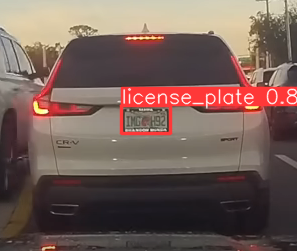

In [257]:
# img = 'drupal.jpg'
# img = 'https://c8.alamy.com/comp/B8PD15/1985-vehicle-license-plate-texas-usa-B8PD15.jpg'
img = 'imgh92.png'

# perform inference
from yolov5.models.common import Detections
results = model(img, size=1920)
results = model(img, augment=True)
assert isinstance(results, Detections)

# crop to plate and read text
cropped = results.crop(save=False)[0]['im']
cropped_w, cropped_h = len(cropped[0]), len(cropped)
texts = reader.readtext(cropped, width_ths=0.8)

candidates = []
for (corners,text,conf) in texts:
    w,h = compute_dimensions(corners)
    percentage_of_space = int(w*h)/int(cropped_w*cropped_h)
    candidates.append({
        'confidence' : float(conf)*1000//1/1000,
        'text' : str(text),
        'percentage_of_space' : float(percentage_of_space*100//1/100),
    })

candidates.sort(key=lambda c:c['percentage_of_space'], reverse=True)
for c in candidates:
    print(c)

results.show()